# Esame

Riconsideriamo il database Movielens1M disponibile [qui](https://grouplens.org/datasets/movielens/) e studiato nel notebook `2-03-recommenders-cf.ipynb`.

Il dataset include i tre file: 
- `ratings.dat`, containing the ratings
- `movies.dat`, containing meta information on the movies
- `users.dat`, containing meta information on the users. 


L'esercitazione consiste nei seguenti passi. 

1. Caricare il dataset `movies.dat` e costruire la tabella di features come mostrato nel notebook `2-04-recommenders-cb.ipynb`
2. Caricare il dataset `users.dat` e costruire una tabella di features ispirandosi a quanto mostrato mostrato nel notebook `2-04-recommenders-cb.ipynb`
3. Caricare il dataset `ratings.dat` ed effettuare delle operazioni di pulizia elementare, come mostrato nel notebook costruire la tabella di features come mostrato nel notebook `2-03-recommenders-cf.ipynb`. Binarizzare l'attributo `rating` in 0 (se il `rating`$<2$) e 1 (se il `rating`$>3$). Eliminare tutte le tuple con `rating`$=3$. 
4. Costruire una nuova tabella che, partendo dalle tuple `(user,item,rating_binario)` della tabella di ratings costruisce una nuova tupla `(user_features,item_features,rating_binario)`. `user_features` e `item_features` sono le features ricostruite nei punti 3 e 2, rispettivamente. 
5. Applicare modellazione predittiva alla tabella appena costruita scegliendo un algoritmo "naive" e `xgboost` e confrontarne le performance, effettuando gli step necessari per ottenere un'accuratezza accettabile. 

## 1. Processamento `movies`

**LIBRERIE DA UTILIZZARE**

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_curve
import scikitplot as skplt
from xgboost import XGBClassifier

Si carica il dataset movies.dat. La funzione lambda permette di splittare i valori contenuti all'interno del file.

In [2]:
movies = pd.read_csv('/Users/vincenzo/Desktop/DS/Unical/19_Data_mining/notebooks/data/ml-1m/movies.dat',sep="::",names=['movieId','title','genres'], encoding='latin-1')
movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),"[Animation, Children's, Comedy]"
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"


Si contano il numero di film per genere.

In [3]:
from collections import Counter

genres_counts = Counter(g for genres in movies['genres'] for g in genres)
print(f"There are {len(genres_counts)} genre labels.")
genres_counts

There are 18 genre labels.


Counter({'Animation': 105,
         "Children's": 251,
         'Comedy': 1200,
         'Adventure': 283,
         'Fantasy': 68,
         'Romance': 471,
         'Drama': 1603,
         'Action': 503,
         'Crime': 211,
         'Thriller': 492,
         'Horror': 343,
         'Sci-Fi': 276,
         'Documentary': 127,
         'War': 143,
         'Musical': 114,
         'Mystery': 106,
         'Film-Noir': 44,
         'Western': 68})

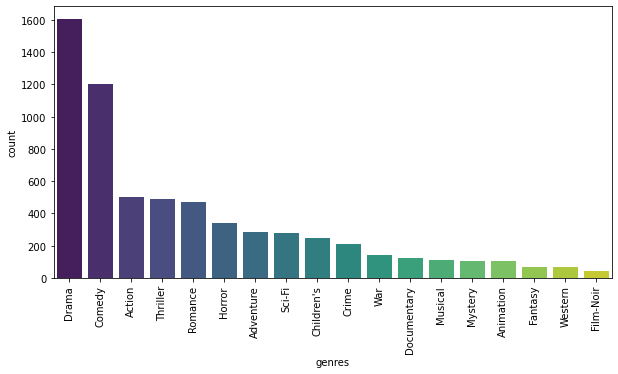

In [4]:
genres_counts_df = pd.DataFrame([genres_counts]).T.reset_index()
genres_counts_df.columns = ['genres', 'count']
genres_counts_df = genres_counts_df.sort_values(by='count', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='genres', y='count', data=genres_counts_df, palette='viridis')
plt.xticks(rotation=90)
plt.show()

A questo punto si estrae l'anno dal titolo dei film e si forma una nuova colonna.

In [5]:
import re 

def extract_year_from_title(title):
    t = title.split(' ')
    year = None
    p = re.search(r'\(\d+\)', t[-1])
    if p:
        year = p.group(0).strip('()')
        year = int(year)
    return year


title = "Associate, The (L'Associe)(1982)"
year = extract_year_from_title(title)
print(f"Year of release: {year}")
print(type(year))

Year of release: 1982
<class 'int'>


In [6]:
movies['year'] = movies['title'].apply(extract_year_from_title)
movies.head()

,movieId,title,genres,year
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995


Si fa pulizia dei valori nulli nella colonna "year".

In [7]:
movies['year'].isnull().sum()

0

In [8]:
movies['year'].nunique()

81

In [9]:
movies = movies[~movies['year'].isnull()]
movies = movies[movies['year'] != 0]
print(f"Number of movies after removing null years: {movies['movieId'].nunique()}")

Number of movies after removing null years: 3883


A questo punto si formano le varie decadi e si plottano facendo un count dei film.

In [10]:
movies['decade'] = movies['year'].map(lambda x: x - (x%10))

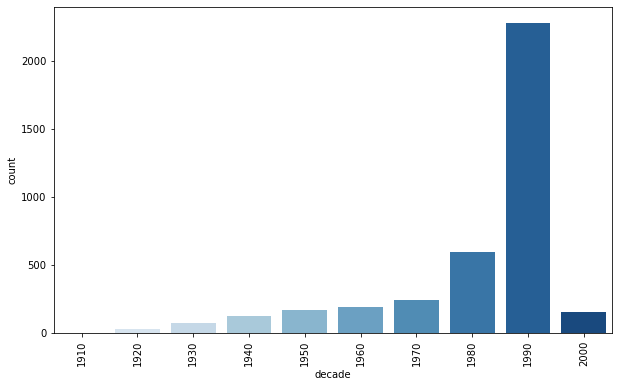

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(movies['decade'], palette='Blues')
plt.xticks(rotation=90)
plt.show()

Si splittano i vari generi in diverse colonne e si binarizza il tutto, in modo da assegnare ai diversi film le varie categorie diverse a cui appartengono.

In [12]:
genres = list(genres_counts.keys())

for g in genres:
    movies[g] = movies['genres'].transform(lambda x: int(g in x))
    
movies.head()

,movieId,title,genres,year,decade,Animation,Children's,Comedy,Adventure,Fantasy,...,Crime,Thriller,Horror,Sci-Fi,Documentary,War,Musical,Mystery,Film-Noir,Western
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,1990,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),"[Adventure, Children's, Fantasy]",1995,1990,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995,1990,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Waiting to Exhale (1995),"[Comedy, Drama]",1995,1990,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II (1995),[Comedy],1995,1990,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Si generano delle dummies per le decadi e successivamente si fa la tabella delle feature che contiene i generi e le decadi.

In [13]:
movie_decades = pd.get_dummies(movies['decade'].astype(int))
movie_decades.head()

,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,1,0


In [14]:
movie_features = pd.concat([movies[genres], movie_decades], axis=1)
movie_features = pd.concat([movies['movieId'],movie_features],axis=1)
movie_features.head()

,movieId,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,...,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## 2. Processamento `users`

Si carica il dataset "users.dat". Anche in questo caso si utilizza il separatore specifico affinché il file possa essere letto.

In [15]:
columns = 'userId::gender::age::occupation::zip-code'.split("::")
users = pd.read_csv('/Users/vincenzo/Desktop/DS/Unical/19_Data_mining/notebooks/data/ml-1m/users.dat',sep="::",names=columns, encoding='latin-1')
users.head(3)

,userId,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117


Si generano le dummies per la colonna età. La variabile è discretizzata e contiene dei range disponibili nel file "READ ME". Dato che si deve variare il nome delle colonne "1" e "18", in quanto ci sono delle colonne con lo stesso nome e, dunque, l'algoritmo xgboost non ammette colonne uguali, si cambia il nome a tutte le colonne rappresentanti i range di età.

Si generano anche le dummies per la variabile occupation e si genera la tabella delle features per users.

In [16]:
users_age = pd.get_dummies(users['age'].astype(int))
users_age.head()

,1,18,25,35,45,50,56
0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0


In [17]:
users_age.rename(columns = {1:'eta_1'}, inplace = True)
users_age.rename(columns = {18:'eta_18'}, inplace = True)
users_age.rename(columns = {25:'eta_25'}, inplace = True)
users_age.rename(columns = {35:'eta_35'}, inplace = True)
users_age.rename(columns = {45:'eta_45'}, inplace = True)
users_age.rename(columns = {50:'eta_50'}, inplace = True)
users_age.rename(columns = {56:'eta_56'}, inplace = True)
users_age.head

<bound method NDFrame.head of       eta_1  eta_18  eta_25  eta_35  eta_45  eta_50  eta_56
0         1       0       0       0       0       0       0
1         0       0       0       0       0       0       1
2         0       0       1       0       0       0       0
3         0       0       0       0       1       0       0
4         0       0       1       0       0       0       0
...     ...     ...     ...     ...     ...     ...     ...
6035      0       0       1       0       0       0       0
6036      0       0       0       0       1       0       0
6037      0       0       0       0       0       0       1
6038      0       0       0       0       1       0       0
6039      0       0       1       0       0       0       0

[6040 rows x 7 columns]>

In [18]:
users_occupation= pd.get_dummies(users['occupation'].astype(int))
users_occupation.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
users_features = pd.concat([users['userId'], users['gender'], users_age, users_occupation], axis=1)
users_features.head()

,userId,gender,eta_1,eta_18,eta_25,eta_35,eta_45,eta_50,eta_56,0,...,11,12,13,14,15,16,17,18,19,20
0,1,F,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,M,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,3,M,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,M,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,M,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [20]:
def partition(x):
    if x =='F':
        return 0
    elif x=='M':
        return 1
 
users_features['gender']  = users_features['gender'].map(partition)

In [21]:
users_features.head()

,userId,gender,eta_1,eta_18,eta_25,eta_35,eta_45,eta_50,eta_56,0,...,11,12,13,14,15,16,17,18,19,20
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,3,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 3. Processamento `ratings`

Si carica il file ratings.

In [22]:
columns = ['userId','movieId','rating','timestamp']
ratings = pd.read_csv('/Users/vincenzo/Desktop/DS/Unical/19_Data_mining/notebooks/data/ml-1m/ratings.dat',sep="::",names=columns)
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [23]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 1000209
Number of unique movieId's: 3706
Number of unique users: 6040
Average number of ratings per user: 165.6
Average number of ratings per movie: 269.89


Si binarizza la variabile rating:
 - Rating <= 2 sarà uguale a 0
 - Rating > 3 sarà uguale a 1.
 - Si eliminano i valori rating = 3.

In [24]:
def partition(x):
    if x <=2:
        return 0
    elif x>3:
        return 1

ratings = ratings[ratings['rating'] != 3]  
ratings['rating']  = ratings['rating'].map(partition)

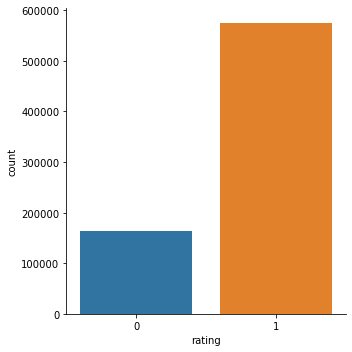

In [25]:
import seaborn as sn
g = sn.catplot(x='rating', data=ratings, kind="count")

In [26]:
ratings['rating'].isna().sum()

0

## 4. Tabella di analisis

Si unisco le diverse tabelle delle features.

In [27]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1193,1,978300760
3,1,3408,1,978300275
4,1,2355,1,978824291
6,1,1287,1,978302039
7,1,2804,1,978300719


In [28]:
movie_features.head()

,movieId,Animation,Children's,Comedy,Adventure,Fantasy,Romance,Drama,Action,Crime,...,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,3,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,4,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,5,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [29]:
users_features.head()

,userId,gender,eta_1,eta_18,eta_25,eta_35,eta_45,eta_50,eta_56,0,...,11,12,13,14,15,16,17,18,19,20
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
2,3,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [30]:
result = pd.merge(ratings, users_features, on="userId")

In [31]:
finale = pd.merge(result,movie_features, on="movieId")

In [32]:
result.head(5)

,userId,movieId,rating,timestamp,gender,eta_1,eta_18,eta_25,eta_35,eta_45,...,11,12,13,14,15,16,17,18,19,20
0,1,1193,1,978300760,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3408,1,978300275,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,2355,1,978824291,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1287,1,978302039,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2804,1,978300719,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
finale.head(5)

,userId,movieId,rating,timestamp,gender,eta_1,eta_18,eta_25,eta_35,eta_45,...,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
0,1,1193,1,978300760,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2,1193,1,978298413,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,12,1193,1,978220179,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,15,1193,1,978199279,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,17,1193,1,978158471,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [34]:
print(list(finale.columns))

['userId', 'movieId', 'rating', 'timestamp', 'gender', 'eta_1', 'eta_18', 'eta_25', 'eta_35', 'eta_45', 'eta_50', 'eta_56', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 'Animation', "Children's", 'Comedy', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Sci-Fi', 'Documentary', 'War', 'Musical', 'Mystery', 'Film-Noir', 'Western', 1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000]


In [35]:
finale = finale.drop(['userId', 'movieId','timestamp'], axis=1)

In [36]:
finale.head(5)

,rating,gender,eta_1,eta_18,eta_25,eta_35,eta_45,eta_50,eta_56,0,...,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


Si valuta l'eventuale sbilanciamento della variabile **rating**

In [37]:
finale['rating'].value_counts()
tot = 575281+163731
perc1 = (575281/tot)*100
perc2 = (163731/tot)*100
print(perc1)
print(perc2)

77.84460874789583
22.155391252104163


Siccome la variabile rating assume valore pari a 0 nel 77,84% e valore pari a 1 nel 22,16%, non c'è bisogno di fare nessuna operazione di oversampling. 

## 5. Modellazione predittiva

Si sistema la tabella in modo da poter splittare in train e test set più agevolmente. Nello specifico rating la si sposta come prima colonna.

In [38]:
mysubset = ["rating"]
mysubset
mask = finale.columns.isin(mysubset)
pd.concat([finale.loc[:,mask], finale.loc[:,~mask]], axis=1)

,rating,gender,eta_1,eta_18,eta_25,eta_35,eta_45,eta_50,eta_56,0,...,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
0,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,1,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739007,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
739008,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
739009,1,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
739010,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [39]:
y = finale.rating

In [40]:
X = finale.drop(['rating'],axis=1).select_dtypes(exclude=['object'])

Si fissa il seme e si splitta in train e test.

In [41]:
seed = 1234
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [42]:
X_train.head()

,gender,eta_1,eta_18,eta_25,eta_35,eta_45,eta_50,eta_56,0,1,...,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000
216468,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
308844,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
278406,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
373309,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
347039,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


**KKN**

Il primo modello da considerare è il K Neighbors.

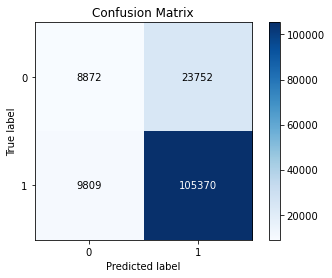

              precision    recall  f1-score   support

           0       0.47      0.27      0.35     32624
           1       0.82      0.91      0.86    115179

    accuracy                           0.77    147803
   macro avg       0.65      0.59      0.60    147803
weighted avg       0.74      0.77      0.75    147803



In [43]:
k = 10
knn = KNeighborsClassifier(n_neighbors=k)

knn.fit(X_train, y_train)


pred_y = knn.predict(X_test)

skplt.metrics.plot_confusion_matrix(y_test, pred_y,list(y_test.unique()),normalize=False)
plt.show()

print(classification_report(y_test, pred_y))

Si trova:
- Una accuratezza del 77%.
- La Specificità ammonta al 47,5%. Indica la percentuale di rating = 0 correttamente identificati
- la sensitività all' 82% (precision). Indica la percentuale di rating = 1 correttamente identificati
- La recall al 91%, ovvero i veri positivi su veri positivi e falsi negativi.


**DECISION TREE**

Il secondo modello implementato è quello del decision tree.

In [44]:
from sklearn.tree import DecisionTreeClassifier
tree_depth = 5
decision_tree = DecisionTreeClassifier(max_depth=tree_depth)
decision_tree.fit(X_train,y_train)


DecisionTreeClassifier(max_depth=5)

In [45]:
pred_y = decision_tree.predict(X_test)

              precision    recall  f1-score   support

           0       0.55      0.10      0.16     32624
           1       0.79      0.98      0.88    115179

    accuracy                           0.78    147803
   macro avg       0.67      0.54      0.52    147803
weighted avg       0.74      0.78      0.72    147803

AUC:  0.5369848970735067


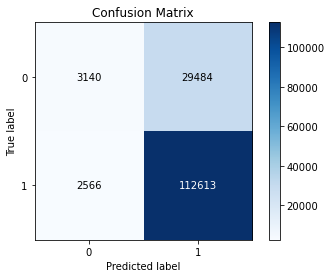

In [46]:
skplt.metrics.plot_confusion_matrix(y_test, pred_y,list(y_test.unique()),normalize=False)
print(classification_report(y_test, pred_y))
fpr, tpr, thresholds = roc_curve(y_test, pred_y, pos_label=1)
print("AUC: ", auc(fpr, tpr))

In questo caso l'accuratezza è del 78%. Aumenta la recall, che è al 98%, ma diminuisce la precisione. 

**RANDOM FORESTS**

Il terzo modello scelto è il random forests. Si setta una size uguale a 500 e successivamente si calcola la matrice di confusione.

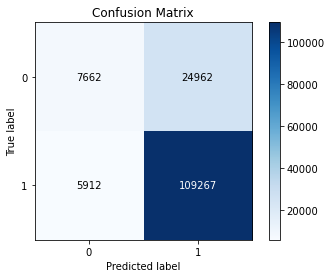

              precision    recall  f1-score   support

           0       0.56      0.23      0.33     32624
           1       0.81      0.95      0.88    115179

    accuracy                           0.79    147803
   macro avg       0.69      0.59      0.60    147803
weighted avg       0.76      0.79      0.76    147803



In [47]:
from sklearn.ensemble import RandomForestClassifier 

# inizializiamo il RF
random_forest_size = 500
random_forest = RandomForestClassifier(n_estimators=random_forest_size, random_state=seed)

# fase di learning
random_forest.fit(X_train, y_train)

# calcoliamo le predizioni
pred_y = random_forest.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, pred_y,list(y_test.unique()),normalize=False)
plt.show()
print(classification_report(y_test, pred_y))

Si trova:
- Una accuratezza del 79%.
- La Specificità ammonta al 56%. Indica la percentuale di rating = 0 correttamente identificati
- la sensitività all' 81% (precision). Indica la percentuale di rating = 1 correttamente identificati
- La recal al 95%

Basandosi sull'accuratezza, questo è il modello migliore rispetto ai due precedenti.

**XGB**

Si passa all'implementazione dell'xgboost. 

Come parametri si fissano:
- max_depth=5
- numero di epoche = 100 
- learning rate = 1

tutti gli altri rimangono settati come da default.

Come metrica si sceglie "error" in quanto si è di fronte ad un problema di classificazione binaria.

In [43]:
xgb = XGBClassifier(use_label_encoder=False,verbosity=0,max_depth=5,n_estimators=100,eta=1,subsample=0.6,objective='binary:logistic')
evalset = [(X_train, y_train), (X_test,y_test)]
xgb.fit(X_train, y_train,eval_set=evalset, eval_metric="error")

[0]	validation_0-error:0.21851	validation_1-error:0.21684
[1]	validation_0-error:0.21869	validation_1-error:0.21688
[2]	validation_0-error:0.21828	validation_1-error:0.21680
[3]	validation_0-error:0.21732	validation_1-error:0.21598
[4]	validation_0-error:0.21713	validation_1-error:0.21592
[5]	validation_0-error:0.21618	validation_1-error:0.21510
[6]	validation_0-error:0.21525	validation_1-error:0.21424
[7]	validation_0-error:0.21494	validation_1-error:0.21391
[8]	validation_0-error:0.21429	validation_1-error:0.21328
[9]	validation_0-error:0.21380	validation_1-error:0.21295
[10]	validation_0-error:0.21307	validation_1-error:0.21266
[11]	validation_0-error:0.21268	validation_1-error:0.21216
[12]	validation_0-error:0.21258	validation_1-error:0.21222
[13]	validation_0-error:0.21229	validation_1-error:0.21217
[14]	validation_0-error:0.21152	validation_1-error:0.21133
[15]	validation_0-error:0.21081	validation_1-error:0.21053
[16]	validation_0-error:0.21063	validation_1-error:0.21048
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=1, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

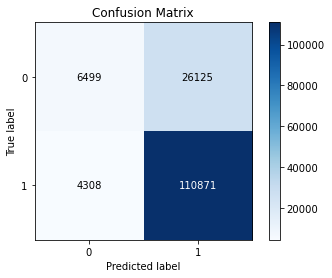

              precision    recall  f1-score   support

           0       0.60      0.20      0.30     32624
           1       0.81      0.96      0.88    115179

    accuracy                           0.79    147803
   macro avg       0.71      0.58      0.59    147803
weighted avg       0.76      0.79      0.75    147803



In [44]:
pred_y = xgb.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, pred_y,list(y_test.unique()),normalize=False)
plt.show()
print(classification_report(y_test, pred_y))

Si trova:
- Una accuratezza del 79%.
- La Specificità ammonta al 60%. Indica la percentuale di rating = 0 correttamente identificati
- la sensitività all' 81%% (precision). Indica la percentuale di rating = 1 correttamente identificati
- La recall al 96%

In termini di accuratezza i risultati dell'xgboost sono simili a quelli derivanti dal random forests. 

Si plotta il grafico della loss (in questo caso la metrica utilizzata è la "error"). Da quanto si evince non c'è overfitting, almeno fino all'epoca 50. Per tale motivo si implementa un modello xgb con meno epoche.

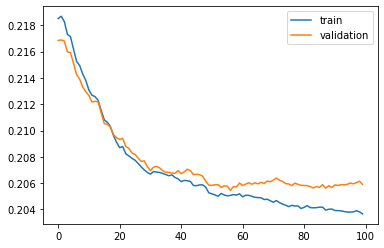

In [45]:
results = xgb.evals_result()

plt.plot(results['validation_0']['error'], label='train')
plt.plot(results['validation_1']['error'], label='validation')
# show the legend
plt.legend()
# show the plot
plt.show()

Si plotta la **feature importance** delle prime 20 variabili

<AxesSubplot:>

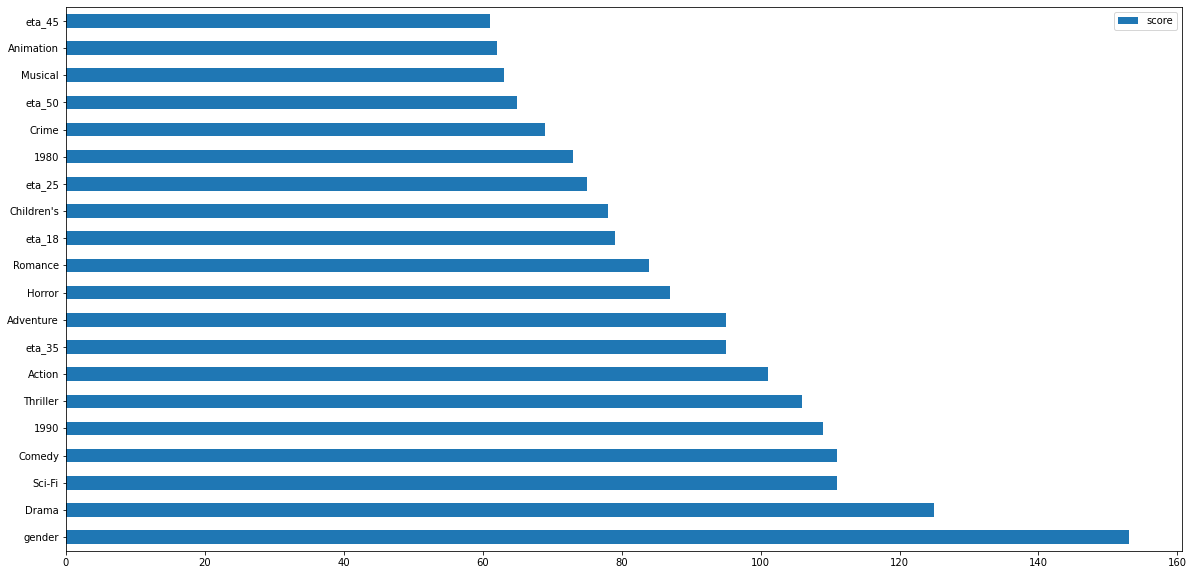

In [51]:
feature_important = xgb.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10)) 


Le 5 variabili più importanti sono le ultime e sono relative al genere. Si può, dunque, affermare che il genere del film influenza il rating dato al film stesso. 

**CONFRONTO CRUVE ROC MODELLI**

Si confrontano le curve roc e le curve della recall dei diversi modelli finora utilizzati.

In [52]:
def plot_accuracy_metrics(model_list, Xtest, ytest, label_idx=1, model_names=None):
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(22,10))
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_ylabel('True Positive Rate')
    ax1.set_xlabel('False Positive Rate')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    
    for i, model in enumerate(model_list):
        proba = model.predict_proba(Xtest)
        probs = proba[:,label_idx]
    
        if model_names:
            mname = model_names[i]
        else:
            mname = 'model '+str(i)

        # plot the AUC curves
        fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label=1)
        aucv = auc(fpr,tpr)

        ax1.plot(fpr,tpr,label=f'{mname}, AUC={aucv:.2f}')
        ax1.plot([0, 1], [0, 1],'k--')

        # plot the precision-recall curves
        precision, recall, _ = precision_recall_curve(ytest, probs, pos_label=1)
        pr_auc = auc(recall, precision)

        no_skill = len(ytest[ytest==1]) / len(ytest)
        ax2.plot([0, 1], [no_skill, no_skill], 'k--')
        ax2.plot(recall, precision, label=f'{mname}, PR-AUC={pr_auc:.2f}')


    ax1.legend(loc = 'lower right')
    ax2.legend(loc = 'lower left')

    plt.show()


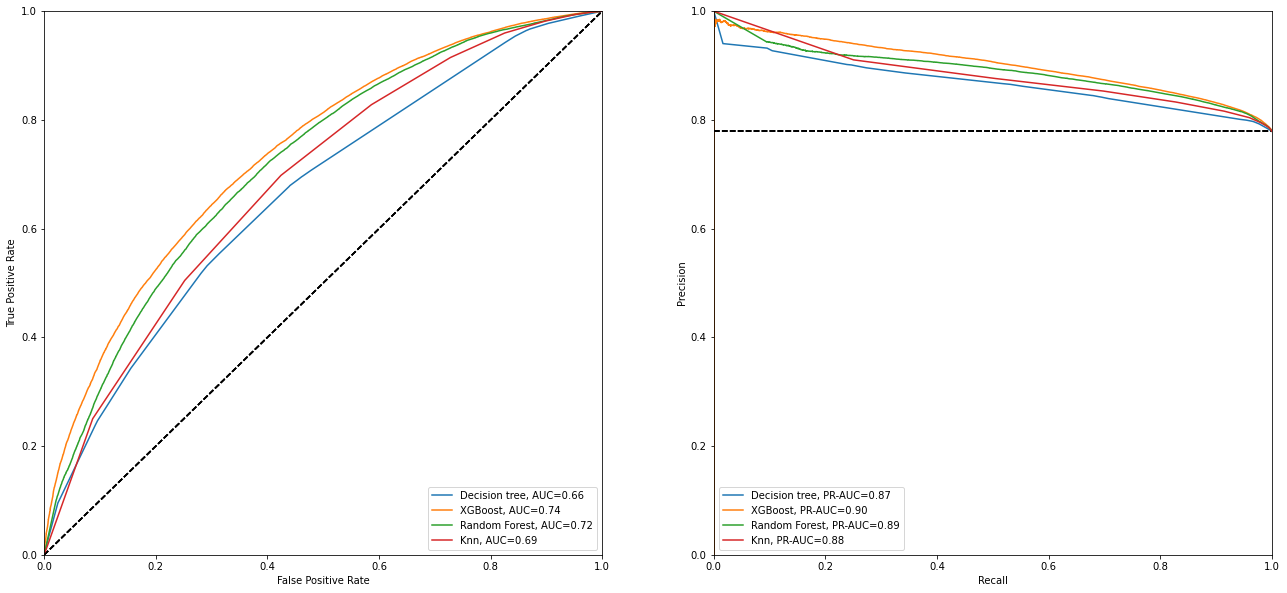

In [53]:
plot_accuracy_metrics([decision_tree,xgb,random_forest,knn],X_test, y_test, model_names=['Decision tree','XGBoost','Random Forest','Knn' ])

In base all'area al di sotto della curva ROC, il modello più performante è quello dell'XGBoost. È da considerare anche performante il random forests dato che è molto vicino all'XGBoost. Il peggior modello risulta essere il decision tree. Magari adoperando il tuning del modello, si potrebbe ottenere un risultato migliore

**PROVA CON MENO EPOCHE**

In [54]:
xgb2 = XGBClassifier(use_label_encoder=False,verbosity=0,max_depth=5,n_estimators=50,eta=1,subsample=0.6,objective='binary:logistic')
evalset = [(X_train, y_train), (X_test,y_test)]
xgb2.fit(X_train, y_train,eval_set=evalset, eval_metric="error")

[0]	validation_0-error:0.21851	validation_1-error:0.21684
[1]	validation_0-error:0.21869	validation_1-error:0.21688
[2]	validation_0-error:0.21828	validation_1-error:0.21680
[3]	validation_0-error:0.21732	validation_1-error:0.21598
[4]	validation_0-error:0.21713	validation_1-error:0.21592
[5]	validation_0-error:0.21618	validation_1-error:0.21510
[6]	validation_0-error:0.21525	validation_1-error:0.21424
[7]	validation_0-error:0.21494	validation_1-error:0.21391
[8]	validation_0-error:0.21429	validation_1-error:0.21328
[9]	validation_0-error:0.21380	validation_1-error:0.21295
[10]	validation_0-error:0.21307	validation_1-error:0.21266
[11]	validation_0-error:0.21268	validation_1-error:0.21216
[12]	validation_0-error:0.21258	validation_1-error:0.21222
[13]	validation_0-error:0.21229	validation_1-error:0.21217
[14]	validation_0-error:0.21152	validation_1-error:0.21133
[15]	validation_0-error:0.21081	validation_1-error:0.21053
[16]	validation_0-error:0.21063	validation_1-error:0.21048
[17]	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eta=1, gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

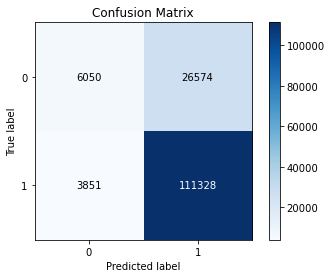

              precision    recall  f1-score   support

           0       0.61      0.19      0.28     32624
           1       0.81      0.97      0.88    115179

    accuracy                           0.79    147803
   macro avg       0.71      0.58      0.58    147803
weighted avg       0.76      0.79      0.75    147803



In [55]:
pred_y2 = xgb2.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, pred_y2,list(y_test.unique()),normalize=False)
plt.show()
print(classification_report(y_test, pred_y2))

I risultati sono più o meno equivalenti a quelli trovati con 100 epoche. Aumenta solo la recall e la specificità.

# XGBOOST - tuning degli iperparametri!

Si ricerca quali sono i migliori valori di alcuni iperparametri per vedere se il modello ha performance più elevate sul test. Nello specifico si prendono in considerazione diversi valori di:
- learning rate;
- gamma, che specifica la riduzione minima della loss per splittare un nodo;
- reg_alpha, che funziona come la Lasso regression, ovvero è utile quando c'è alta dimensionalità in modo da rendere più veloce l'algoritmo;
- reg_lambda, che funziona come la Ridge regression, ovvero è un iperparametro di regolarizzazione dell'XGBoost.

In [56]:
from sklearn.model_selection import GridSearchCV
params = {'eta': [0.01, 0.05, 0.1],
           'gamma':[0.2,0.6,1],
           'reg_alpha': [0, 0.5, 1],
           'reg_lambda':[0.5,1,4]}
xgb3 = XGBClassifier(use_label_encoder=False,verbosity=0,subsample=0.6,objective='binary:logistic', max_depth=5, n_estimators=100)
clf = GridSearchCV(estimator=xgb3, 
                   param_grid=params,
                   scoring='accuracy')

In [57]:
import time
start = time.time()
clf.fit(X_train, y_train)
print('Best score:', clf.best_score_)
print("Best parameters:", clf.best_params_)
end = time.time()
print(end - start)

Best score: 0.7866659660441545
Best parameters: {'eta': 0.1, 'gamma': 0.2, 'reg_alpha': 0, 'reg_lambda': 0.5}
8042.260199308395


[0]	validation_0-error:0.21851	validation_1-error:0.21684
[1]	validation_0-error:0.21851	validation_1-error:0.21684
[2]	validation_0-error:0.21820	validation_1-error:0.21681
[3]	validation_0-error:0.21971	validation_1-error:0.21845
[4]	validation_0-error:0.21824	validation_1-error:0.21701
[5]	validation_0-error:0.21823	validation_1-error:0.21702
[6]	validation_0-error:0.21826	validation_1-error:0.21706
[7]	validation_0-error:0.21772	validation_1-error:0.21623
[8]	validation_0-error:0.21811	validation_1-error:0.21672
[9]	validation_0-error:0.21973	validation_1-error:0.21870
[10]	validation_0-error:0.21793	validation_1-error:0.21648
[11]	validation_0-error:0.21956	validation_1-error:0.21845
[12]	validation_0-error:0.21986	validation_1-error:0.21889
[13]	validation_0-error:0.21985	validation_1-error:0.21889
[14]	validation_0-error:0.21985	validation_1-error:0.21894
[15]	validation_0-error:0.21986	validation_1-error:0.21899
[16]	validation_0-error:0.21883	validation_1-error:0.21801
[17]	va

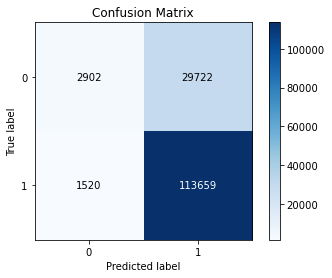

              precision    recall  f1-score   support

           0       0.66      0.09      0.16     32624
           1       0.79      0.99      0.88    115179

    accuracy                           0.79    147803
   macro avg       0.72      0.54      0.52    147803
weighted avg       0.76      0.79      0.72    147803



In [46]:
xgb1 = XGBClassifier(use_label_encoder=False,verbosity=0,max_depth=5,gamma=0.2,reg_aplha=0,reg_lambda=0.5,n_estimators=100,eta= 0.1, subsample=0.6,objective='binary:logistic')
evalset = [(X_train, y_train), (X_test,y_test)]
xgb1.fit(X_train, y_train,eval_set=evalset, eval_metric="error")

# calcoliamo le predizioni
pred_y1 = xgb1.predict(X_test)
skplt.metrics.plot_confusion_matrix(y_test, pred_y1,list(y_test.unique()),normalize=False)
plt.show()
print(classification_report(y_test, pred_y1))

I risultati in termini di precisione peggiorano, mentre aumentano in termini di specificità e recall. L'accuratezza rimane invariata.

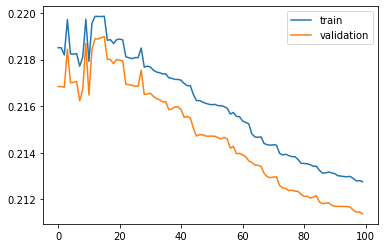

In [47]:
results = xgb1.evals_result()

plt.plot(results['validation_0']['error'], label='train')
plt.plot(results['validation_1']['error'], label='validation')
plt.legend()
plt.show()

Si può notare come il train error sia superiore al test error. Per questo motivo, è difficile affermare che questo sia un buon modello. 

Il problema può essere dato dal fatto che non si sono trovati tutti i "best parameters" dell'xgboost. Il tempo di computerizzazione per trovare tutti i "best parameters" risulta essere troppo elevato, dunque si è preferito non ricercarli tutti.

Il modello xgboost preso di riferimento è il primo!

# CONCLUSIONI

In linea di massima, per predirre al meglio il valore binario del rating si potrebbe utilizzare o il random forests oppure l'xgboost Classifier, con quest'ultimo che risulta avere una specificità più alta rispetto al random forests e un'area sotto la curva ROC maggiore. In più, da quanto riscontrato dalla feature importance, il rating viene influenzano principalmente dal genere del film. I rating alti sono classificati in modo corretto nell'81% dei casi, mentre i rating bassi al 60%. Ad ogni modo, considerando che l'accuratezza è uguale e l'area al di sotto della curva ROC non è tanto differente tra Random Forests e XGBoost, si potrebbe preferire quest'ultimo anche in base alla velocità di computerizzazione.